**ideas**

*   slowly turn the robot until it's split (half and half)
*   use a linear regression model to determine how much to turn based on contour size
*   ...



In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import skimage.color
from sklearn.linear_model import LinearRegression

In [2]:
def find_largest_contour(contours):
  largest = max(contours, key = cv2.contourArea)
  return largest

In [3]:
def bgr_to_rgb(image):
  return image[:,:,::-1]



# old alignment from center of largest contour

In [ ]:
import cv2
import numpy as np
# from matplotlib import pyplot as plt
import math
def find_largest_contour(contours):
   if(len(contours) > 0):
       largest = max(contours, key = cv2.contourArea)
       return largest
   return None
 
PIXEL_BUFFER = 30
img_w = 320
def align_with_hub(largest_contour):
  x,y,rect_w,rect_h = cv2.boundingRect(largest_contour)
  x_center = x + rect_w/2
  if x_center < img_w/2 + PIXEL_BUFFER and x_center > img_w/2 - PIXEL_BUFFER:
    print("ready to shoot")
    print(x_center)
  elif x_center > img_w/2 - PIXEL_BUFFER:
    # move slightly right
    print("move right")
    print(x_center)
    #align_with_hub() # put new photo after moving robot
  else:
    # move slightly left
    print("move left")
    print(x_center)
    #align_with_hub() # put new photo after moving robot

def getMask(image):
  img = image.astype(np.uint8) #need to convert type to UINT8 because the cv2.threshold() function doesn't accept the original image type
  return cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)[1]

def runPipeline(image, llrobot):
  img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  mask = getMask(img)
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  largest_contour = find_largest_contour(contours)
  align_with_hub(largest_contour)
  #return ([[[0, 0]], [[0, 100]], [[100, 0]], [[100, 100]]], cv2.drawContours(output_image, [goal], 0, (0, 0, 255), 3), output)

# mask-tape contour

In [81]:
FULL = 250

def draw_contour(name):
  img = cv2.imread(name)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img = img[int(FULL/8):int(3*FULL/8),:]
  img = cv2.blur(img, (2, 2))

  imgray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  ret, thresh = cv2.threshold(imgray, 10, 240, 0)

  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  liz = [] #list of contours with correct aspect ratio
  leftX = 400
  rightX = -1
  for contour in contours:
    x,y,width,height = cv2.boundingRect(contour)
    aspect = width/height #should be around 2.5 (5/2)
    if(aspect < 5 and aspect > 0.5 and height < width and width*height < 600 and width*height > 30):
      liz.append(contour)
      if x < leftX: 
        leftX = x
      if x + width > rightX:
        rightX = x + width

  img = skimage.color.yuv2rgb(img)

  for con in liz:
    x, y, w, h = cv2.boundingRect(con)
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)
    print(w, h)
  plt.imshow(img)
  plt.show()
  return (rightX + leftX)/2


In [89]:
PIXEL_BUFFER = 30
img_w = 320
def align_with_hub(centerX):
  if centerX < img_w/2 + PIXEL_BUFFER and centerX > img_w/2 - PIXEL_BUFFER:
    print("ready to shoot")
    print(centerX)
  elif centerX > img_w/2 - PIXEL_BUFFER:
    # move slightly right
    print("move right")
    print(centerX)
    #align_with_hub() # put new photo after moving robot
  else:
    # move slightly left
    print("move left")
    print(centerX)
    #align_with_hub() # put new photo after moving robot


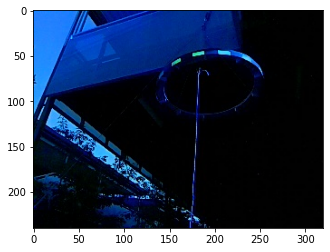

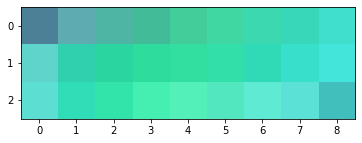

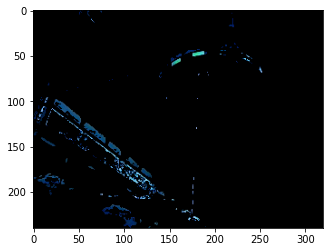

[ 0.64853304  0.02986617 -0.33895488]
[0.06069028 0.02728164 0.06637001]


In [91]:
# code to find known yuv values
th = cv2.imread("right.jpeg")
plt.imshow(th)
plt.show()

imgyuv = skimage.color.rgb2yuv(th)

knownyuv = skimage.color.rgb2yuv(th[47:50, 176:185])
plt.imshow(th[47:50, 176:185])
plt.show()

knownyuv = np.reshape(knownyuv, (-1, 3))

red_mean_color_yuv = knownyuv.mean(axis = 0)
red_stddev_color_yuv = knownyuv.std(axis = 0)

meanR = [0.64853304, 0.02986617, -0.33895488]
stddevR = [0.06069028, 0.02728164, 0.06637001]

scale = 4
low_threshold = np.array([0.0,
                          red_mean_color_yuv[1] - scale * red_stddev_color_yuv[1],
                          red_mean_color_yuv[2] - scale * red_stddev_color_yuv[2]])

high_threshold = np.array([1.0,
                          red_mean_color_yuv[1] + scale * red_stddev_color_yuv[1],
                          red_mean_color_yuv[2] + scale * red_stddev_color_yuv[2]])

background_mask = np.all((imgyuv > low_threshold) * (imgyuv < high_threshold), axis=2)
background_mask = np.where(background_mask, 1, 0)
background_mask = np.expand_dims(background_mask, 2)

th = th*background_mask
cv2.imwrite("mid.jpeg", th)
plt.imshow(th)
plt.show()

print(red_mean_color_yuv)
print(red_stddev_color_yuv)

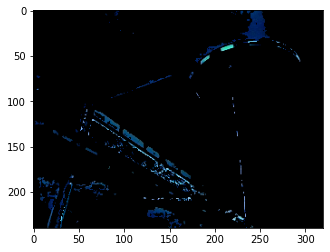

[ 0.16400784  0.17017006 -0.14388129]
[ 0.64853304  0.02986617 -0.33895488]
[0]
20 6


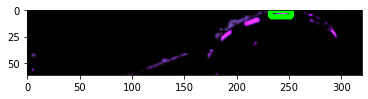

move right
242.0


In [92]:
# code to run on new photos
im = cv2.imread("veryRight.jpeg")
# plt.imshow(im)
# plt.show()

imgyuv = skimage.color.rgb2yuv(im)

scale = 4
low_threshold = np.array([0.0,
                        meanR[1] - scale * stddevR[1],
                        meanR[2] - scale * stddevR[2]])

high_threshold = np.array([1.0,
                        meanR[1] + scale * stddevR[1],
                        meanR[2] + scale * stddevR[2]])

background_mask = np.all((imgyuv > low_threshold) * (imgyuv < high_threshold), axis=2)
background_mask = np.where(background_mask, 1, 0)
background_mask = np.expand_dims(background_mask, 2)

im = im*background_mask
cv2.imwrite("mid.jpeg", im)
plt.imshow(im)
plt.show()

print(imgyuv[48, 150])
print(red_mean_color_yuv)
print(background_mask[48, 150])

align_with_hub(draw_contour("mid.jpeg"))